<a href="https://colab.research.google.com/github/t1seo/AIFFEL_Hackerthon-1/blob/main/taewon/week_plot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- [Surprised Yet? - Part2 - (LB: 0.503)](https://www.kaggle.com/jdpaletto/surprised-yet-part2-lb-0-503)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd /content/drive/MyDrive/data/Restaurant_Visitor_Forecasting

/content/drive/MyDrive/data/Restaurant_Visitor_Forecasting


In [3]:
import numpy as np
import pandas as pd
from sklearn import ensemble, neighbors, linear_model, metrics, preprocessing
from datetime import datetime

## 데이터 불러오기

In [4]:
data = {
    'tra': pd.read_csv('air_visit_data.csv'),
    'as': pd.read_csv('air_store_info.csv'),
    'hs': pd.read_csv('hpg_store_info.csv'),
    'ar': pd.read_csv('air_reserve.csv'),
    'hr': pd.read_csv('hpg_reserve.csv'),
    'id': pd.read_csv('store_id_relation.csv'),
    'tes': pd.read_csv('sample_submission.csv'),
    'hol': pd.read_csv('date_info.csv').rename(columns={'calendar_date':'visit_date'})
}

# 데이터 전처리

### hpg 데이터 중에서 store_id_relation에 있는 id만 사용한다

`hpg` 데이터에는 타깃 데이터인 `visitors`가 없다. (`visitors`는 `air_visit_data`에 있다)

키 값이 없는 `hpg` 데이터는 과감히 쳐내준다.

#### ===코멘트 수정 필요====

In [5]:
data['id'] # id는 총 150개

,air_store_id,hpg_store_id
0,air_63b13c56b7201bd9,hpg_4bc649e72e2a239a
1,air_a24bf50c3e90d583,hpg_c34b496d0305a809
2,air_c7f78b4f3cba33ff,hpg_cd8ae0d9bbd58ff9
3,air_947eb2cae4f3e8f2,hpg_de24ea49dc25d6b8
4,air_965b2e0cf4119003,hpg_653238a84804d8e7
...,...,...
145,air_b8925441167c3152,hpg_0cc0abae3a8b52de
146,air_f8233ad00755c35c,hpg_098e4dd30e54fee6
147,air_6607fe3671242ce3,hpg_1004356dc8ab69ec
148,air_ccd19a5bc5573ae5,hpg_df22bf146d2c7e19


- `id`는 총 150개이고 `hpg` 데이터 중에서 `id`에 있는 데이터들만 사용을 한다.

In [6]:
len(data['hr'])

2000320

In [7]:
# hpg_reserve.csv에 store_id_relation.csv를 hpg_store_id 기준으로 inner merge
data['hr'] = pd.merge(data['hr'], data['id'], how='inner', on=['hpg_store_id'])

data['hr'].head()

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors,air_store_id
0,hpg_878cc70b1abc76f7,2016-01-01 19:00:00,2016-01-01 15:00:00,4,air_db80363d35f10926
1,hpg_878cc70b1abc76f7,2016-01-02 19:00:00,2016-01-02 14:00:00,2,air_db80363d35f10926
2,hpg_878cc70b1abc76f7,2016-01-03 18:00:00,2016-01-02 20:00:00,6,air_db80363d35f10926
3,hpg_878cc70b1abc76f7,2016-01-06 20:00:00,2016-01-04 22:00:00,3,air_db80363d35f10926
4,hpg_878cc70b1abc76f7,2016-01-11 18:00:00,2016-01-11 14:00:00,2,air_db80363d35f10926


In [8]:
len(data['hr'])

28183

- `id`만 있는 데이터들만 `merge`한 결과 데이터 개수가 크게 줄었다. 
    - 2000320 -> 28183

## 시계열 데이터 처리
- 연월일시 -> 연월일
- `reserve_datetime_diff` 컬럼 생성(예약한 시간 - 방문 예정 시간)

---
*reserve_datetime_diff* 상관관계

In [9]:
for df in ['ar', 'hr']:
    data[df]['visit_datetime'] = pd.to_datetime(data[df]['visit_datetime'])
      # str을 datetime으로 변환
    data[df]['visit_datetime'] = data[df]['visit_datetime'].dt.date
      # datetime을 dt.date로 변환 
    data[df]['reserve_datetime'] = pd.to_datetime(data[df]['reserve_datetime'])
      # str을 datetime으로 변환
    data[df]['reserve_datetime'] = data[df]['reserve_datetime'].dt.date
      # datetime을 dt.date로 변환 
    data[df]['reserve_datetime_diff'] = data[df].apply(lambda r: (r['visit_datetime'] - r['reserve_datetime']).days, axis=1)
      # difference time을 의미하는 변수 생성 (예약한 시간 - 실제 방문 시간)
    # data[df] = data[df].groupby(['air_store_id','visit_datetime'], as_index=False)[['reserve_datetime_diff', 'reserve_visitors']].sum()
    # data[df] = data[df].rename(columns={'visit_datetime':'visit_date'})
      # air_reserve와 hpg_ reserve로 group을 나눔
# print(data[df].head())

In [10]:
data['ar'].head()

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,reserve_datetime_diff
0,air_877f79706adbfb06,2016-01-01,2016-01-01,1,0
1,air_db4b38ebe7a7ceff,2016-01-01,2016-01-01,3,0
2,air_db4b38ebe7a7ceff,2016-01-01,2016-01-01,6,0
3,air_877f79706adbfb06,2016-01-01,2016-01-01,2,0
4,air_db80363d35f10926,2016-01-01,2016-01-01,5,0


In [11]:
data['hr'].head()

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors,air_store_id,reserve_datetime_diff
0,hpg_878cc70b1abc76f7,2016-01-01,2016-01-01,4,air_db80363d35f10926,0
1,hpg_878cc70b1abc76f7,2016-01-02,2016-01-02,2,air_db80363d35f10926,0
2,hpg_878cc70b1abc76f7,2016-01-03,2016-01-02,6,air_db80363d35f10926,1
3,hpg_878cc70b1abc76f7,2016-01-06,2016-01-04,3,air_db80363d35f10926,2
4,hpg_878cc70b1abc76f7,2016-01-11,2016-01-11,2,air_db80363d35f10926,0


### `air_store_id`와 `visit_datetime`으로 `groupby`

In [12]:
for df in ['ar', 'hr']:
    data[df] = data[df].groupby(['air_store_id','visit_datetime'], as_index=False)[['reserve_datetime_diff', 'reserve_visitors']].sum()
    data[df] = data[df].rename(columns={'visit_datetime':'visit_date'})

In [13]:
data['ar'].head()

,air_store_id,visit_date,reserve_datetime_diff,reserve_visitors
0,air_00a91d42b08b08d9,2016-10-31,0,2
1,air_00a91d42b08b08d9,2016-12-05,4,9
2,air_00a91d42b08b08d9,2016-12-14,6,18
3,air_00a91d42b08b08d9,2016-12-17,6,2
4,air_00a91d42b08b08d9,2016-12-20,2,4


In [14]:
data['hr'].head()

,air_store_id,visit_date,reserve_datetime_diff,reserve_visitors
0,air_00a91d42b08b08d9,2016-01-14,3,2
1,air_00a91d42b08b08d9,2016-01-15,6,4
2,air_00a91d42b08b08d9,2016-01-16,3,2
3,air_00a91d42b08b08d9,2016-01-22,3,2
4,air_00a91d42b08b08d9,2016-01-29,6,5


- `visit_datetime`에서 날짜만 뽑아서 새로운 컬럼을 만들어준다.
- `lambda` 함수를 이용해 방문 예정 시간 `visit_datetime`과 예약한 시간 `reserve_datetime`을 뺴줘 새로운 컬럼인 `reserve_datetime_diff`를 만들어준다.


## training data (`air_visit_data`) feature 추가

In [15]:
data['tra']

,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29
3,air_ba937bf13d40fb24,2016-01-16,22
4,air_ba937bf13d40fb24,2016-01-18,6
...,...,...,...
252103,air_24e8414b9b07decb,2017-04-18,6
252104,air_24e8414b9b07decb,2017-04-19,6
252105,air_24e8414b9b07decb,2017-04-20,7
252106,air_24e8414b9b07decb,2017-04-21,8


### 요일(dow), 연(year), 월(month)를 의미하는 컬럼 추가

In [16]:
# air_visit_data

data['tra']['visit_date'] = pd.to_datetime(data['tra']['visit_date'])
  # str을 datetime으로 변환
data['tra']['dow'] = data['tra']['visit_date'].dt.dayofweek
  # 요일을 의미하는 숫자 변수 생성
data['tra']['year'] = data['tra']['visit_date'].dt.year
  # 년도 year 변수 생성
data['tra']['month'] = data['tra']['visit_date'].dt.month
  # 달 month 변수 생성
data['tra']['visit_date'] = data['tra']['visit_date'].dt.date
  # datetime을 dt.date로 변환
data['tra'].head()

,air_store_id,visit_date,visitors,dow,year,month
0,air_ba937bf13d40fb24,2016-01-13,25,2,2016,1
1,air_ba937bf13d40fb24,2016-01-14,32,3,2016,1
2,air_ba937bf13d40fb24,2016-01-15,29,4,2016,1
3,air_ba937bf13d40fb24,2016-01-16,22,5,2016,1
4,air_ba937bf13d40fb24,2016-01-18,6,0,2016,1


- `test` 셋에는 총 821개의 식당이 있다.

In [17]:

# sample_submission

data['tes']['visit_date'] = data['tes']['id'].map(lambda x: str(x).split('_')[2])
  # id 변수에서 날짜를 뽑아와 visit_date 변수 생성
data['tes']['air_store_id'] = data['tes']['id'].map(lambda x: '_'.join(x.split('_')[:2]))
  # id 변수에서 store id를 뽑아와 air_store_id 변수 생성
data['tes']['visit_date'] = pd.to_datetime(data['tes']['visit_date'])
  # str을 datetime으로 변환
data['tes']['dow'] = data['tes']['visit_date'].dt.dayofweek
  # 요일을 의미하는 숫자 변수 생성
data['tes']['year'] = data['tes']['visit_date'].dt.year
  # 년도 year 변수 생성
data['tes']['month'] = data['tes']['visit_date'].dt.month
  # 달 month 변수 생성
data['tes']['visit_date'] = data['tes']['visit_date'].dt.date
  # datetime을 dt.date로 변환

data['tes'].head()

,id,visitors,visit_date,air_store_id,dow,year,month
0,air_00a91d42b08b08d9_2017-04-23,0,2017-04-23,air_00a91d42b08b08d9,6,2017,4
1,air_00a91d42b08b08d9_2017-04-24,0,2017-04-24,air_00a91d42b08b08d9,0,2017,4
2,air_00a91d42b08b08d9_2017-04-25,0,2017-04-25,air_00a91d42b08b08d9,1,2017,4
3,air_00a91d42b08b08d9_2017-04-26,0,2017-04-26,air_00a91d42b08b08d9,2,2017,4
4,air_00a91d42b08b08d9_2017-04-27,0,2017-04-27,air_00a91d42b08b08d9,3,2017,4


In [18]:
unique_stores = data['tes']['air_store_id'].unique() # air_store id만을 뽑아낸다.

# 일주일에 해당하는 만큼 unique_stores x 7
stores = pd.concat([pd.DataFrame({'air_store_id': unique_stores, 
                                  'dow': [i] * len(unique_stores)}) for i in range(7)], 
                   axis=0, 
                   ignore_index=True).reset_index(drop=True)

print(len(stores))

5747


In [19]:
stores.tail(7)

,air_store_id,dow
5740,air_fe22ef5a9cbef123,6
5741,air_fe58c074ec1445ea,6
5742,air_fea5dc9594450608,6
5743,air_fee8dcf4d619598e,6
5744,air_fef9ccb3ba0da2f7,6
5745,air_ffcc2d5087e1b476,6
5746,air_fff68b929994bfbd,6


## 가게의 '요일별' `visitors`의 산술 통계량 계산

In [20]:
# 산술 통계량을 뽑아내서 feature로 train data에 추가해준다 -> 자료

tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].min().rename(columns={'visitors':'min_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow']) 
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].mean().rename(columns={'visitors':'mean_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow'])
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].median().rename(columns={'visitors':'median_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow'])
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].max().rename(columns={'visitors':'max_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow'])
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].count().rename(columns={'visitors':'count_observations'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow']) 

stores.head()

,air_store_id,dow,min_visitors,mean_visitors,median_visitors,max_visitors,count_observations
0,air_00a91d42b08b08d9,0,1.0,22.457143,19.0,47.0,35.0
1,air_0164b9927d20bcc3,0,2.0,7.500000,6.0,19.0,20.0
2,air_0241aa3964b7f861,0,2.0,8.920635,8.0,23.0,63.0
3,air_0328696196e46f18,0,2.0,6.416667,4.0,27.0,12.0
4,air_034a3d5b40d5b1b1,0,1.0,11.864865,10.0,66.0,37.0


In [21]:
print(len(stores))

5747


## 요일별 통계량에 `air_store_info` merge

In [22]:
# air store를 stores에 merge
stores = pd.merge(stores, data['as'], how='left', on=['air_store_id']) 
stores.head()

,air_store_id,dow,min_visitors,mean_visitors,median_visitors,max_visitors,count_observations,air_genre_name,air_area_name,latitude,longitude
0,air_00a91d42b08b08d9,0,1.0,22.457143,19.0,47.0,35.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595
1,air_0164b9927d20bcc3,0,2.0,7.500000,6.0,19.0,20.0,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
2,air_0241aa3964b7f861,0,2.0,8.920635,8.0,23.0,63.0,Izakaya,Tōkyō-to Taitō-ku Higashiueno,35.712607,139.779996
3,air_0328696196e46f18,0,2.0,6.416667,4.0,27.0,12.0,Dining bar,Ōsaka-fu Ōsaka-shi Nakanochō,34.701279,135.528090
4,air_034a3d5b40d5b1b1,0,1.0,11.864865,10.0,66.0,37.0,Cafe/Sweets,Ōsaka-fu Ōsaka-shi Ōhiraki,34.692337,135.472229


## 연휴 데이터 전처리

In [23]:
data['hol']

,visit_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
1,2016-01-02,Saturday,1
2,2016-01-03,Sunday,1
3,2016-01-04,Monday,0
4,2016-01-05,Tuesday,0
...,...,...,...
512,2017-05-27,Saturday,0
513,2017-05-28,Sunday,0
514,2017-05-29,Monday,0
515,2017-05-30,Tuesday,0


### 요일을 라벨 인코딩

In [24]:
lbl = preprocessing.LabelEncoder()


data['hol']['visit_date'] = pd.to_datetime(data['hol']['visit_date'])
data['hol']['day_of_week'] = lbl.fit_transform(data['hol']['day_of_week'])
data['hol']['visit_date'] = data['hol']['visit_date'].dt.date
data['hol']

,visit_date,day_of_week,holiday_flg
0,2016-01-01,0,1
1,2016-01-02,2,1
2,2016-01-03,3,1
3,2016-01-04,1,0
4,2016-01-05,5,0
...,...,...,...
512,2017-05-27,2,0
513,2017-05-28,3,0
514,2017-05-29,1,0
515,2017-05-30,5,0


## train 데이터에 holiday 데이터 merge

In [25]:
  # holiday의 날짜 변수 가공한뒤 merge
train = pd.merge(data['tra'], data['hol'], how='left', on=['visit_date']) 

train.head()

,air_store_id,visit_date,visitors,dow,year,month,day_of_week,holiday_flg
0,air_ba937bf13d40fb24,2016-01-13,25,2,2016,1,6,0
1,air_ba937bf13d40fb24,2016-01-14,32,3,2016,1,4,0
2,air_ba937bf13d40fb24,2016-01-15,29,4,2016,1,0,0
3,air_ba937bf13d40fb24,2016-01-16,22,5,2016,1,2,0
4,air_ba937bf13d40fb24,2016-01-18,6,0,2016,1,1,0


## test 데이터에 holiday 데이터 merge

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(0.0, 30.0)

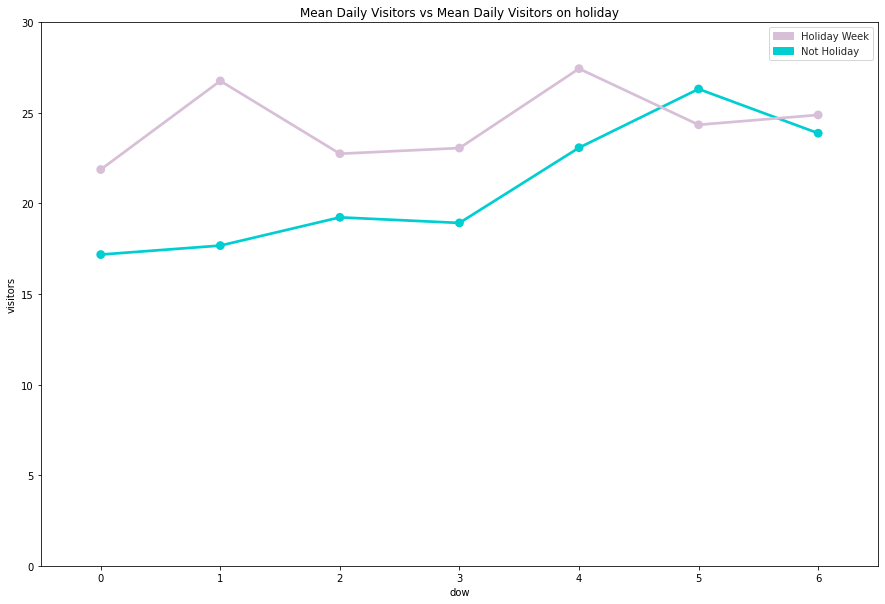

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

train_1 = train
pvt_1 = train_1.groupby(['dow'])['visitors'].mean().reset_index()

train_2 = train.loc[train['holiday_flg'] == 1]
pvt_2 = train_2.groupby(['dow'])['visitors'].mean().reset_index()


f, ax=plt.subplots(figsize=(15,10), sharey=False)
sns.set_style('whitegrid')
ax = sns.pointplot(pvt_1['dow'] ,pvt_1['visitors'], color='darkturquoise')
ax = sns.pointplot(pvt_2['dow'] ,pvt_2['visitors'], color='thistle')

ax.set_title('Mean Daily Visitors vs Mean Daily Visitors on holiday')

import matplotlib.patches as mpatches
holiday = mpatches.Patch(color='thistle', label='Holiday Week')
not_holiday = mpatches.Patch(color='darkturquoise', label='Not Holiday')
plt.legend(handles=[holiday, not_holiday])

sns.set_style("darkgrid", {"axes.facecolor": ".9"})

ax.set_ylim(0, 30)